In [13]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
import cv2
import os

# Indica que será utilizada a ordem das dimensões do Theano
from keras import backend as K
K.set_image_dim_ordering('th')

# Indica que os gráficos serão mostrados no jupyter
%matplotlib inline

In [14]:
def load_data():
    # Separa os dados e rótulos de treinamento e validação
    (data_train, label_train), (data_test, label_test) = mnist.load_data()

    # Realiza o reshape para ficar com 60k imagens, com canal 1 para escala de cinza, com tamanho 28x28
    data_train = data_train.reshape(data_train.shape[0], 1, 28, 28).astype('float32')
    print("Shape dos dados de treinamento: ", data_train.shape)

    # Realiza o reshape também para os dados de validação
    data_test = data_test.reshape(data_test.shape[0], 1, 28, 28).astype('float32')
    print("Shape dos dados de validação: ", data_test.shape)

    # Faz com que os dados fiquem com valores entre 0 e 1 ao invés de 0 e 255
    data_train = data_train / 255
    data_test = data_test / 255

    # Adiciona quantidade total de categorias na posição [1] dos vetores de labels
    label_train = np_utils.to_categorical(label_train)
    print("Shape dos rótulos de treinamento: ", label_train.shape)
    label_test = np_utils.to_categorical(label_test)
    print("Shape dos rótulos de valiação: ", label_train.shape)

    return data_train, label_train, data_test, label_test

In [3]:
# Carrega todos os dados dentro das variáveis
data_train, label_train, data_test, label_test = load_data()

# Número de classes que serão categorizadas
num_classes = label_test.shape[1]

# O model será exportado para este arquivo
filename='mnistneuralnet.h5'

Shape dos dados de treinamento:  (60000, 1, 28, 28)
Shape dos dados de validação:  (10000, 1, 28, 28)


In [4]:
def model():
    # Instancia stack de camadas
    model = Sequential()
    
    # Adiciona camada convolucional, com Kernel = 5x5
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    
    # Adiciona camada de pooling para redução de dimensionalidade (subamostragem)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Outra camada convolucional, com Kernel = 3x3
    model.add(Conv2D(15, (3, 3), input_shape=(1, 28, 28), activation='relu'))

    # Outra camada de pooling para redução de dimensionalidade (subamostragem)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Realiza regularização para desligar alguns neurônios de aleatóriamente com probabilidade de 20%
    model.add(Dropout(0.2))
    
    # Converte matriz para vetor de tamanho único
    model.add(Flatten())

    # Adiciona camadas densamente conectadas com 128, 64 e 32 neurônios
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    # Última camada densa que irá classificar o mesmo número de neurôios que o número de clases
    model.add(Dense(num_classes, activation='softmax', name='predict'))

    # Compila a arquitetura para que o Keras possa formar a rede
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [5]:
# Cria o modelo
model = model()
# Mostra um resumo da arquitetura da rede
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 12, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 10, 10)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 5, 5)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 5, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               48128     
__________

In [6]:
# Verifica se já existe um modelo treinado e exportado para um arquivo .h5.
if not os.path.exists('./{}'.format(filename) ):
    # Um novo modelo será treinado, através do método fit, caso este arquivo não exista.
    model.fit(data_train, label_train, validation_data=(data_test, label_test), epochs=10, batch_size=200)
    model.save_weights(filename)
else:
    # carrega um modelo previamente treinado
    model.load_weights('./{}'.format(filename) )

In [7]:
# Avalia o modelo com base nos dados de validaçãp
scores = model.evaluate(data_test, label_test, verbose=0)
# Exibe a acuracia do modelo criado
print("\nacc: %.2f%%" % (scores[1]*100))


acc: 99.09%


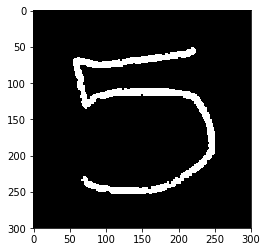

In [10]:
# Lê a imagem extra para teste utilizando o OpenCV
img_pred = cv2.imread("sp_noise.jpg", 0)

# Aplica threshold utilizando uma média dos picos do histograma (Otsu binarization)
_, thresh = cv2.threshold(img_pred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Kernel de 3x3 (as imagens são geralmente de baixa resolução)
kernel = np.ones((3,3), np.uint8)

# Aplica opening na imagem para remoção de ruídos no background
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Aplica closing na imagem para remoção de ruídos no foreground
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# Aplica filtro utilizando kernel que valoriza o valor do ponto central, aumentando a nitidez
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_pred = cv2.filter2D(closing, -1, kernel)

# Exibe a imagem
plt.imshow(img_pred, cmap='gray')

In [11]:
# Verifica se a imagem está nas dimensões corretas (28x28)
if img_pred.shape != [28,28]:
    # Se não estiver, redimensiona a imagem
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)
    
img_pred = img_pred.reshape(1, 1, 28, 28).astype('float32')

img_pred = img_pred/255.0

print(img_pred.shape)

(1, 1, 28, 28)


In [12]:
# Realiza classificação a partir da imagem extra
pred = model.predict_classes(img_pred)

# Calcula a probablidade da classificação estar correta
pred_proba = model.predict_proba(img_pred)

# Imprime a probabilidade
pred_proba = "%.2f%%" % (pred_proba[0][pred]*100)
print(pred[0], " com confiança de ", pred_proba)

5  com confiança de  95.83%
